In [9]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import seaborn as sns
from copy import deepcopy
from os.path import join
import site
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics 
from tqdm import tqdm
site.addsitedir('../include')

from visualize import plot_action_list, get_labels
from utils import load_action_map, f_score, edit_score


## Per video result analysis
- calculate metrics per video
- scatter plot video length / performance

In [5]:
# Experiment 2: Case by case analysis
def get_scores_for_vid(video_id, results_path, ground_truth_dir, overlap=0.25):
    ground_truth = open(join(ground_truth_dir, video_id + '.txt'), 'r').read().split('\n')
    prediction = open(join(results_path, video_id), 'r').read().split('\n')[1].split()
    
    ground_truth = ground_truth[0:len(prediction)] if len(prediction) < len(ground_truth) else ground_truth
    prediction = prediction[0:len(ground_truth)] if len(prediction) >= len(ground_truth) else prediction

    edit = edit_score(prediction, ground_truth, bg_class=[''])
    accuracy = sum([1 for p, g in zip(prediction, ground_truth) if p == g]) / len(prediction) * 100
    tp, fp, tn, fn = f_score(prediction, ground_truth, overlap, bg_class=[''])
    f1 = 2 * tp / (2*tp+fp+fn) * 100
    
    return f1, edit, accuracy


results_path = r"C:\Users\smuel\Pictures\Results WESP\sics73_mse0.3_splits\results"
base_dir = r"C:\Users\smuel\Data\2024_SICS_Phase"
gt_dir = join(base_dir, 'groundTruth2')

#results_path = r"C:\Users\smuel\Pictures\Results WESP\cataract101_rgb\results"
#base_dir = r"C:\Users\smuel\Data\cataract-101"
#gt_dir = join(base_dir, 'groundTruth')

scores = {'video_id': [], 'edit': [], 'f1': [], 'accuracy': [], 'length': []}

for i in range(0, len(os.listdir(gt_dir))):
    ground_truth_path = os.listdir(gt_dir)[i]
    ground_truth_id = os.path.splitext(ground_truth_path)[0]
    if not os.path.exists(join(results_path, ground_truth_id)):
        continue
    
    f1, edit, accuracy = get_scores_for_vid(ground_truth_id, results_path, gt_dir)
    vid_length = len(open(join(gt_dir, ground_truth_path), 'r').readlines()) / 30.0 / 60.0

    # print(f'{ground_truth_id}> edit score: {edit:.2f}, f1@0.25: {f1:.2f}, accuracy: {accuracy:.2f}, video length: {vid_length:.2f}')
    scores['edit'].append(edit)
    scores['f1'].append(f1)
    scores['accuracy'].append(accuracy)
    scores['length'].append(vid_length)
    scores['video_id'].append(ground_truth_id)

print()
print(f'Average edit score: {np.mean(scores["edit"]):.2f}, average f1 score: {np.mean(scores["f1"]):.2f}, average accuracy: {np.mean(scores["accuracy"]):.2f}')


Average edit score: 55.71, average f1 score: 57.20, average accuracy: 71.12


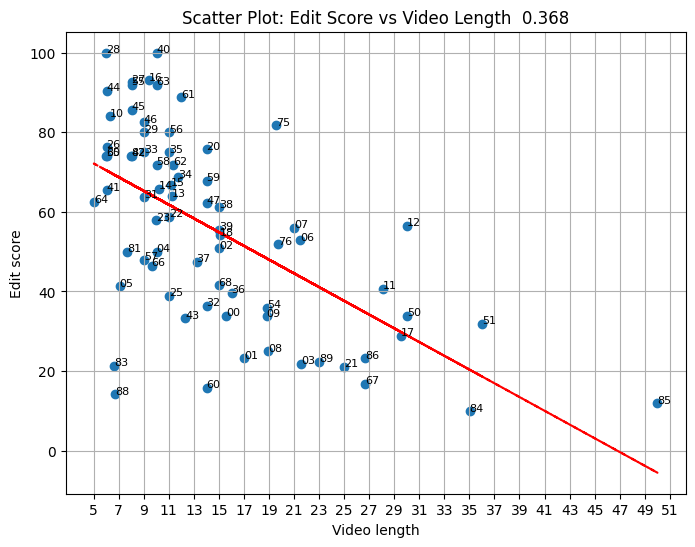

In [8]:
# Scatter plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(scores['length'], scores['edit'])

# Calculate the trend line
z = np.polyfit(scores['length'], scores['edit'], 1)
p = np.poly1d(z)
plt.plot(scores['length'], p(scores['length']), "r--")
for i, identifier in enumerate(scores['video_id']):
    plt.annotate(identifier[-2:], (scores['length'][i], scores['edit'][i]), fontsize=8)

# Calculate residuals
predicted_values = np.polyval(z, scores['length'])
residuals = scores['edit'] - predicted_values
RSS = np.sum(residuals**2)
TSS = np.sum((scores['edit'] - np.mean(scores['edit']))**2)
R_squared = 1 - RSS / TSS # Calculate R-squared

plt.xlabel('Video length')
plt.xticks(np.arange(int(min(scores['length'])), int(max(scores['length'])) + 2, 2.0))
plt.ylabel('Edit score')
plt.title(f'Scatter Plot: Edit Score vs Video Length  {R_squared:.3f}')
plt.grid()
plt.show() # Show the plot


C:\Users\smuel\AppData\Local\Temp\ipykernel_20996\2962679349.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c # Define the exponential model function


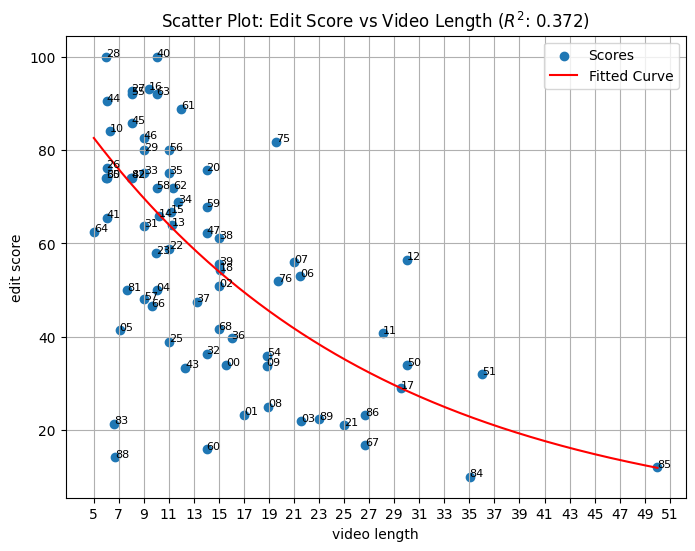

In [10]:
def model_func(x, a, b, c):
    return a * np.exp(-b * x) + c # Define the exponential model function

x_values, y_values = np.array(scores['length']), np.array(scores['edit'])
opt_params, param_cov = optimize.curve_fit(model_func, x_values, y_values, loss='soft_l1', method='trf', max_nfev=20000) # Fit the nonlinear model
xx = np.linspace(min(x_values), max(x_values), 1000) # Generate fitted curve
yy = model_func(xx, *opt_params)

predicted_values = model_func(x_values, *opt_params) # Calculate residuals
residuals = y_values - predicted_values
TSS = np.sum((y_values - np.mean(y_values))**2) # Calculate TSS and RSS
RSS = np.sum(residuals**2)
R_squared = 1 - RSS / TSS # Calculate R-squared

fig = plt.figure(figsize=(8, 6)) # Plot the scatter data and the fitted curve
plt.scatter(x_values, y_values, label='Scores', color=None)
for i, identifier in enumerate(scores['video_id']):
    plt.annotate(identifier[-2:], (x_values[i], y_values[i]), fontsize=8)
plt.plot(xx, yy, label='Fitted Curve', color='red')
plt.xlabel('video length')
plt.xticks(np.arange(int(min(x_values)), int(max(x_values)) + 2, 2.0))
plt.ylabel('edit score')
plt.grid()
plt.legend()
plt.title(f'Scatter Plot: Edit Score vs Video Length ($R^2$: {R_squared:.3f})')
plt.show()

In [ ]:
from scipy import stats

# Calculate the Spearman correlation coefficient
corr, p_value = stats.spearmanr(scores['length'], scores['edit'])
print(f"Spearman correlation coefficient: {corr:.4f} (p={p_value:.8f})")

corr, p_value = stats.pearsonr(scores['length'], scores['edit'])
print(f"Pearson correlation coefficient: {corr:.4f} (p={p_value:.8f})")

Spearman correlation coefficient: -0.5984 (p=0.00000002)
Pearson correlation coefficient: -0.6070 (p=0.00000001)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


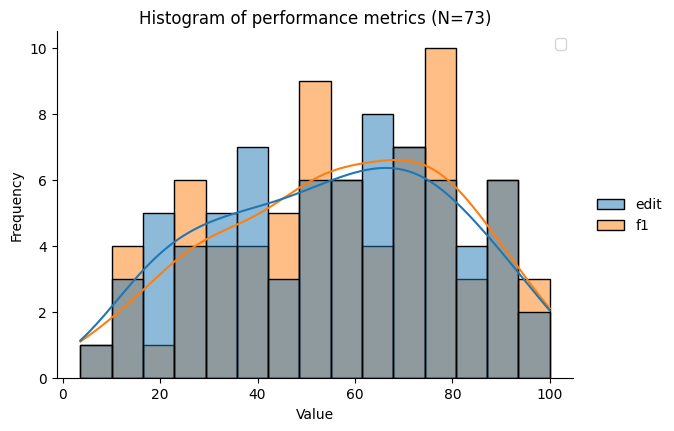

In [7]:
bins = 15
data = deepcopy(scores)
del data['length']
del data['accuracy']
del data['video_id']
# Plot overlapping histograms
# plt.hist(scores['f1'], bins=bins, alpha=0.5, label='F1@0.25', color='orange', ec=None)
sns.displot(data, kde=True, bins=bins, height=4, aspect=1.5)

plt.xlabel('Value') # Add labels and legend
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram of performance metrics (N={len(scores["f1"])})')
plt.show()

## Bootstrap test metrics for CIs

In [8]:
def prepare_results(ground_truth_dir, results_dir, action_dict, sample_rate=1):
    results_files = os.listdir(results_dir)
    probability_files = [file for file in results_files if 'npy' in file]

    actions2num = np.vectorize(lambda d: action_dict[d])
    results = {"labels": [], "predictions": [], "probs": []}

    for probs_files in tqdm(probability_files):
        probs = np.load(join(results_dir, probs_files))[:, 0::sample_rate]
        prediction = open(join(results_dir, probs_files.replace('npy', '')), 'r').read().split('\n')[1].split()
        ground_truth = open(join(ground_truth_dir, probs_files.replace('npy', 'txt')), 'r').read().split('\n')
        ground_truth = ground_truth[0::sample_rate]
        ground_truth = ground_truth[:probs.shape[1]]
        prediction = prediction[0::sample_rate]
        prediction = prediction[:probs.shape[1]]
        assert probs.shape[1] == len(ground_truth)

        ground_truth = actions2num(ground_truth)
        prediction = actions2num(prediction)

        results["labels"].append(ground_truth)
        results["predictions"].append(prediction)
        results["probs"].append(probs)
    return results

results_dir = r"C:\Users\smuel\Pictures\Results WESP\sics88_c13_nobg"
gt_dir = r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth88_c13_nobg"

action_dict = load_action_map(join(results_dir,'mapping.txt'))
rev_actions = {v: k for k, v in action_dict.items()}

results = prepare_results(gt_dir, results_dir, action_dict, sample_rate=10)
print(len(results["labels"]))

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 117.49it/s]

13


In [10]:
def bootstrap_test_metric(results, metric, alpha=0.5, num_samples=300, seed=0):
    rng = np.random.RandomState(seed=seed)
    idx = np.arange(len(results['labels']))
    accumulation_metric = []
    encoder = OneHotEncoder(sparse_output=False)

    for _ in range(num_samples):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        boot_label = [label for j, label in enumerate(results['labels']) if j in pred_idx]
        boot_pred = [pred for j, pred in enumerate(results['predictions']) if j in pred_idx]
        boot_prob = [probs for j, probs in enumerate(results['probs']) if j in pred_idx]
        
        if metric == metrics.roc_auc_score or metric == metrics.average_precision_score:
            y_true = encoder.fit_transform(np.concatenate(boot_label).reshape(-1, 1)).T
            test_mean = metric(y_true.ravel(), np.concatenate(boot_prob, axis=1).ravel(), average='micro')
        else:
            test_mean = metric(np.concatenate(boot_label), np.concatenate(boot_pred))
        
        accumulation_metric.append(test_mean)
    
    bootstrap_mean = np.mean(accumulation_metric)
    ci_lower = np.percentile(accumulation_metric, alpha/2.0)
    ci_upper = np.percentile(accumulation_metric, 100-alpha/2.0)
    return bootstrap_mean, (ci_lower, ci_upper)


print(bootstrap_test_metric(results, metrics.accuracy_score, alpha=5.0, seed=0))
print(bootstrap_test_metric(results, lambda a, b: metrics.f1_score(a, b, average='macro'), alpha=5.0,seed=0))
print(bootstrap_test_metric(results, metrics.roc_auc_score, alpha=5.0, seed=0))
print(bootstrap_test_metric(results, metrics.average_precision_score, alpha=5.0, seed=0))

(0.8074646636935718, (0.7719501877881831, 0.848754951391989))
(0.7712986387538425, (0.730016153159002, 0.8233855330849494))
(0.9734068560256018, (0.9624669020792617, 0.9842611425131328))
(0.8257093426542069, (0.7814895535866706, 0.8741784792427862))
